In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM
import torch.nn.functional as F
from torch.utils.data import DataLoader
import argparse
import os
import copy
import torch
from typing import Any, cast, Dict, List, Tuple
from transformer_lens import HookedTransformer, HookedTransformerConfig
from transformer_lens.loading_from_pretrained import convert_gpt2_weights
os.environ['http_proxy'] = "http://10.176.52.116:7890"
os.environ['https_proxy'] = "http://10.176.52.116:7890"
os.environ['all_proxy'] = "socks5://10.176.52.116:7891"

/remote-home/miintern1/anaconda3/envs/watermark/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/remote-home/miintern1/anaconda3/envs/watermark/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/remote-home/miintern1/anaconda3/envs/watermark/lib/python3.11/site-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return

In [2]:
hf_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf",device_map = 'cpu')
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
tokenizer.pad_token = tokenizer.eos_token

model = HookedTransformer.from_pretrained("Llama-2-7b", device = 'cpu', hf_model=hf_model)
model.eval()

# prompt = "Hey, are you conscious? Can you talk to me?"
# inputs = tokenizer(prompt, return_tensors="pt")

# # Generate
# generate_ids = model.generate(inputs.input_ids, max_length=30)
# tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

Loading checkpoint shards: 100%|██████████| 2/2 [01:38<00:00, 49.38s/it]


Loaded pretrained model Llama-2-7b into HookedTransformer


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-31): 32 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): Hook

In [3]:
from datasets import load_dataset
dataset = load_dataset("allenai/c4", "realnewslike", split="validation", streaming="store_true")

Using the latest cached version of the dataset since allenai/c4 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'realnewslike' at /remote-home/miintern1/.cache/huggingface/datasets/allenai___c4/realnewslike/0.0.0/1588ec454efa1a09f29cd18ddd04fe05fc8653a2 (last modified on Thu Jul  4 09:54:35 2024).


In [4]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
data_iter = iter(dataloader)
batch = next(data_iter)

In [5]:
d_model = 4096
tokenize_output = tokenizer(batch['text'], return_tensors='pt', padding=True, truncation=True, max_length=d_model)
tokens = tokenize_output['input_ids']
attn_mask = tokenize_output['attention_mask']

logits, cache = model.run_with_cache(tokens, attention_mask=attn_mask, return_type = 'logits')

In [6]:
layer = 29
import torch.nn as nn
from pprint import pprint
substituted_layer = f'blocks.{layer}.hook_resid_post'
# cache[substituted_layer]
# fwd_hook = [f"blocks.{layer}.hook_resid_post" for i in layers]
# pprint(list(cache.keys()))
# print(cache['blocks.0.hook_resid_post'] - cache[
#  'blocks.1.hook_resid_pre'])
unemb = nn.Sequential(model.ln_final, model.unembed)
U = torch.transpose(list(unemb[1].parameters())[0],0,1).detach().cpu().float()

print(U.shape)

torch.Size([32000, 4096])


In [14]:
inputs

{'input_ids': tensor([[    1,   910,   338,   385,  1342, 10541, 29889]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [21]:
# Cache dictionaries
activation_cache = {}
gradient_cache = {}

# Hook function to cache activations
def activation_hook(module, input, output, cache, layer_name):
    cache[layer_name] = output

# Hook function to cache gradients
def gradient_hook(module, grad_input, grad_output, cache, layer_name):
    cache[layer_name] = grad_output[0]

# Register hooks to cache activations and gradients
for name, layer in model.named_modules():
    layer.register_forward_hook(lambda module, input, output: activation_hook(module, input, output, activation_cache, name))
    layer.register_backward_hook(lambda module, grad_input, grad_output: gradient_hook(module, grad_input, grad_output, gradient_cache, name))

# Sample input
input_text = "This is an example sentence."
inputs = tokenizer(input_text, return_tensors='pt')

# Forward pass
hf_model.train()
outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
loss = outputs.loss  # Example loss

# Backward pass
loss.backward()

# Access cached activations
print("Cached Activations:", activation_cache.keys())

# Access cached gradients
print("Cached Gradients:", gradient_cache.keys())

/remote-home/miintern1/anaconda3/envs/watermark/lib/python3.11/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


AttributeError: 'Tensor' object has no attribute 'loss'

In [51]:
cache[f'blocks.10.hook_resid_post'].shape#[0].argmax(dim=-1).shape

torch.Size([1, 535, 4096])

/remote-home/miintern1/anaconda3/envs/watermark/lib/python3.11/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
100it [10:20,  6.21s/it]                         
101it [10:20,  6.15s/it]


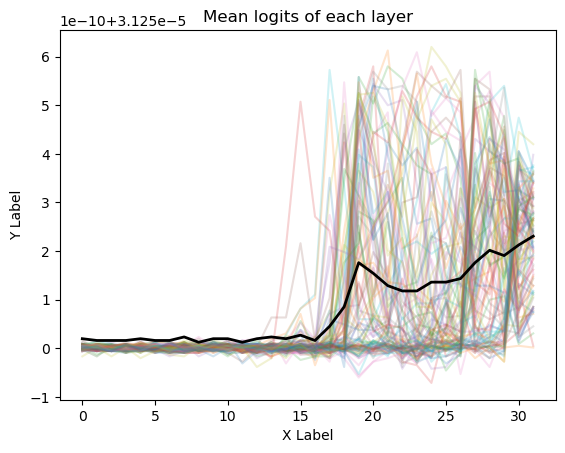

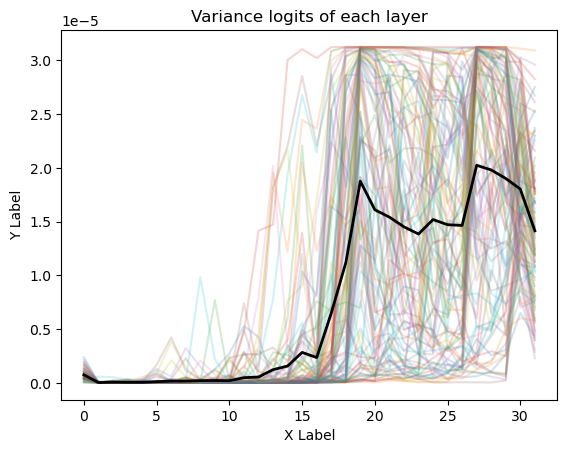

In [8]:
latent_token_probs = []
out_token_probs = []
entropy = []
energy = [] 
latents_all = []
means_all = []
variance_all = []
device = torch.device("cuda:0")
total_runs = 100
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

with torch.backends.cuda.sdp_kernel(enable_flash=False):
    with tqdm(total=total_runs) as pbar:
        for idx, batch in tqdm(enumerate(dataloader)):
            last = []
            latents = []
            tokenize_output = tokenizer(batch['text'], return_tensors='pt', padding=True, truncation=True, max_length=d_model)
            tokens = tokenize_output['input_ids']
            attn_mask = tokenize_output['attention_mask']
            logits, cache = model.run_with_cache(tokens, attention_mask=attn_mask, return_type = 'logits')

            latents = torch.cat([cache[f'blocks.{i}.hook_resid_post'] for i in range(len(model.blocks))])
            # print(f"{latents.shape=}")
            # print(f"{len(model.blocks)=}")
            # print(f"{cache['blocks.1.hook_resid_post'].shape=}")
            logits = unemb(latents)
            # print(f"{logits.shape=}")
            latents = latents.detach().cpu().clone().float()

            # latents = llama.latents_all_layers(d['prompt'])
            # logits = unemb(latents)
            last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
            latents_all.append(last)
            # last, last_indices = torch.topk(last_tensor, k, dim=-1)
            # print(f"{last.shape=}")
            means = torch.mean(last, dim=1)
            variace = torch.var(last, dim=1)
            # print(f"{means.shape=}")
            # print(f"{variace.shape=}")
            means_all.append(means)
            variance_all.append(variace)
            pbar.update(1)
            if idx == total_runs:
                break

            # latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
            # out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
            # entropy += [compute_entropy(last)]

            # latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
            # latents_normalized = latents[:, -1, :].float()

            # latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
            # latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
            # norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
            # energy += [norm/avgUU]

# latent_token_probs = torch.stack(latent_token_probs)
# out_token_probs = torch.stack(out_token_probs)
# entropy = torch.stack(entropy)
# energy = torch.stack(energy)
# latents = torch.stack(latents_all)

for idx, lst in enumerate(means_all):
    plt.plot(lst, alpha=0.2) 
np_mean_all = np.array(means_all)
mean_sum = np.mean(np_mean_all, axis=0)
plt.plot(mean_sum, color='black', linewidth=2)
plt.xlabel('X Label')
plt.ylabel('Y Label')
plt.title('Mean logits of each layer')
plt.show()

for idx, lst in enumerate(variance_all):
    plt.plot(lst, alpha=0.2)
np_var_all = np.array(variance_all)
var_sum = np.mean(np_var_all, axis=0)
plt.plot(var_sum, color='black', linewidth=2)
plt.xlabel('X Label')
plt.ylabel('Y Label')
plt.title('Variance logits of each layer')
plt.show()


In [14]:
latents_tensor.shape

torch.Size([101, 32, 32000])

In [11]:
def plot_with_mean(mean_value, value, title = 'Mean logits of each layer'):
    """
    Plots each list in value with a transparent curve and mean_value as a non-transparent curve.
    
    Args:
        mean_value (torch.Tensor): Tensor of shape (32000,) representing the mean values to be plotted.
        value (torch.Tensor): Tensor of shape (N, 32000) representing the values to be plotted with transparency.
    """
    # Convert the tensors to numpy arrays if they are not already
    mean_value_np = mean_value.numpy() if isinstance(mean_value, torch.Tensor) else mean_value
    value_np = value.numpy() if isinstance(value, torch.Tensor) else value
    
    # Plot each list in value with transparency
    for lst in value_np:
        plt.plot(lst, alpha=0.2)
    
    # Plot the mean_value with non-transparent black curve
    plt.plot(mean_value_np, color='black', linewidth=2)
    
    # Set labels and title
    plt.xlabel('X Label')
    plt.ylabel('Y Label')
    plt.title(title)
    
    # Show the plot
    plt.show()

In [32]:
for layer_latent in latents:
    print(layer_latent.shape)
    break
topk_mean_all.shape

torch.Size([32000])


torch.Size([101, 32])

topk_indices.shape=torch.Size([101, 5])
torch.Size([101, 5])
topk_mean.shape=torch.Size([32])
topk_var.shape=torch.Size([32])


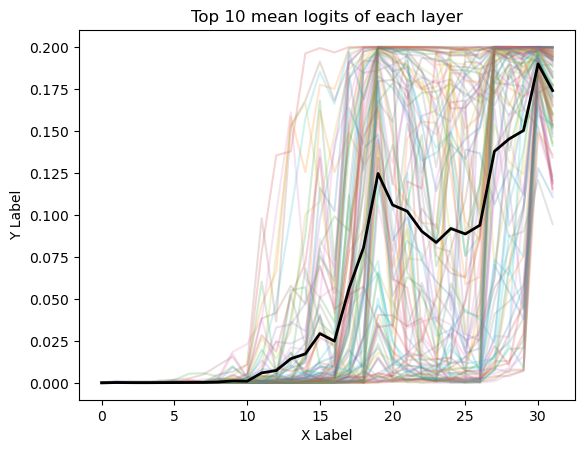

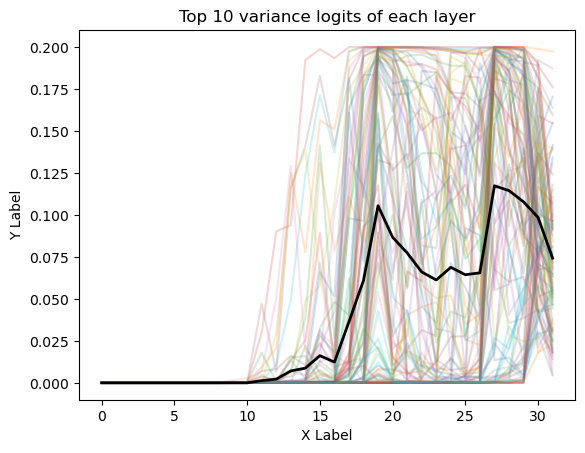

In [44]:
_, topk_indices = torch.topk(latents_tensor, 5, dim=-1)
topk_indices = topk_indices[:,-1,:]
print(f"{topk_indices.shape=}")
topk_mean_all = []
topk_var_all = []
print(topk_indices.shape)
for indices, latents in zip(topk_indices, latents_tensor):
    # print(indices.shape, latents.shape)
    topk_latents =torch.stack([layer_latent[indices] for layer_latent in latents], dim=0)
    # print(topk_latents.shape)
    topk_mean_all.append(torch.mean(topk_latents, dim=-1))
    topk_var_all.append(torch.var(topk_latents, dim=-1))
    # print(topk_mean_all)
topk_mean_all = torch.stack(topk_mean_all)
topk_var_all = torch.stack(topk_var_all)
topk_mean = torch.mean(topk_mean_all, dim=0)
topk_var = torch.mean(topk_var_all, dim=0)
print(f"{topk_mean.shape=}")
print(f"{topk_var.shape=}")

plot_with_mean(topk_mean, topk_mean_all, title='Top 10 mean logits of each layer')
plot_with_mean(topk_var, topk_var_all, title='Top 10 variance logits of each layer')

/tmp/ipykernel_2508800/1969786972.py:7: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  topk_variance_all = torch.var(topk_latents, dim=-1)


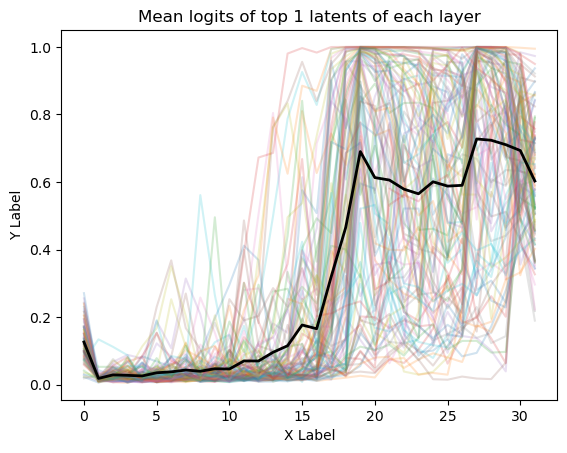

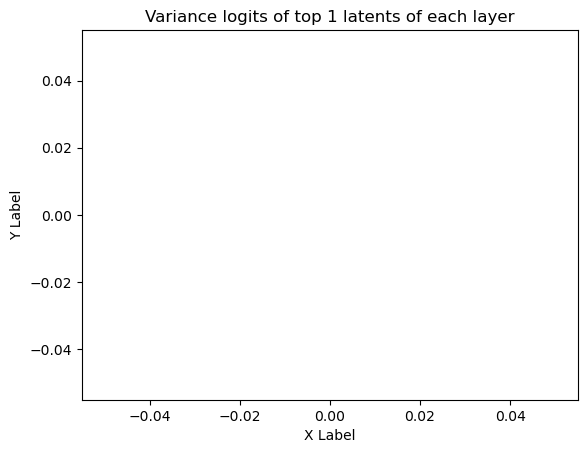

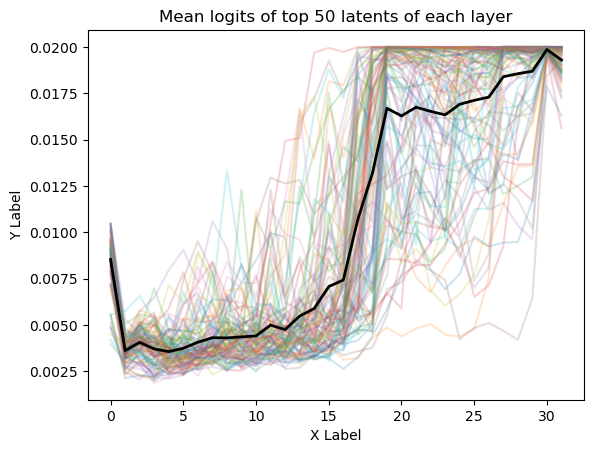

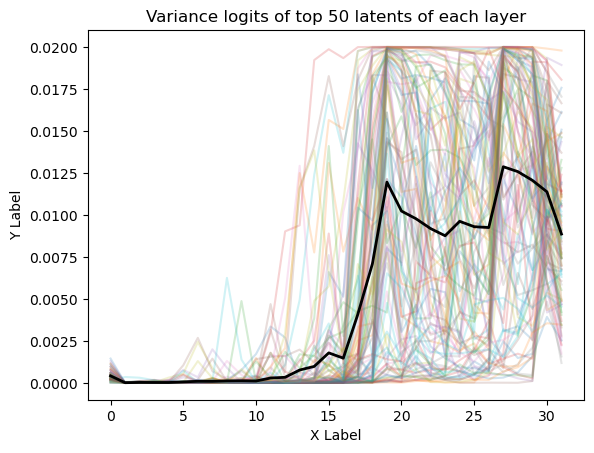

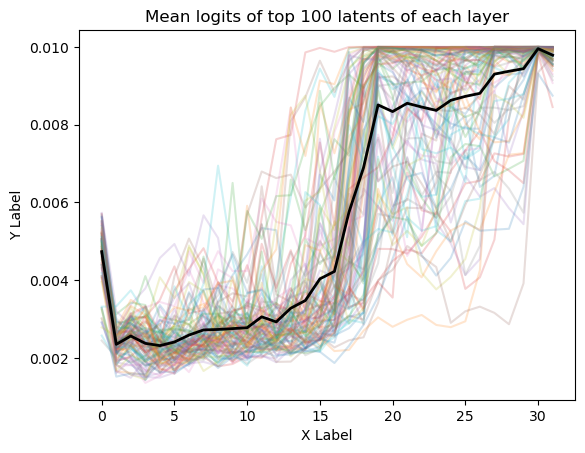

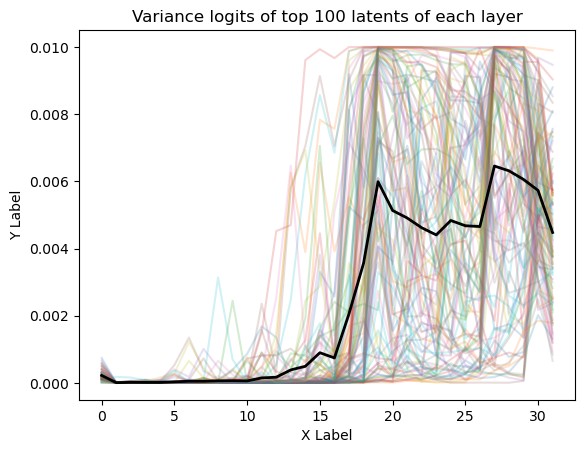

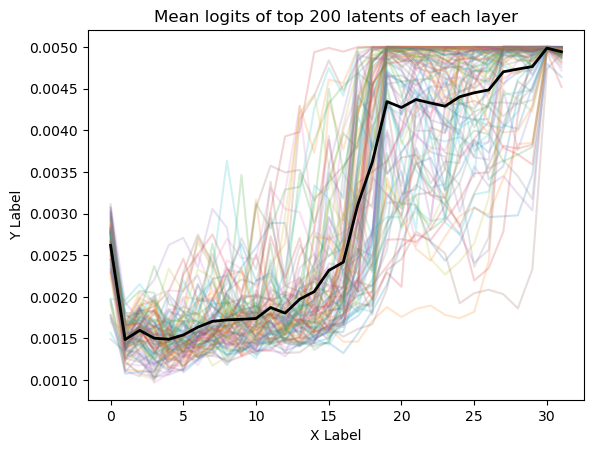

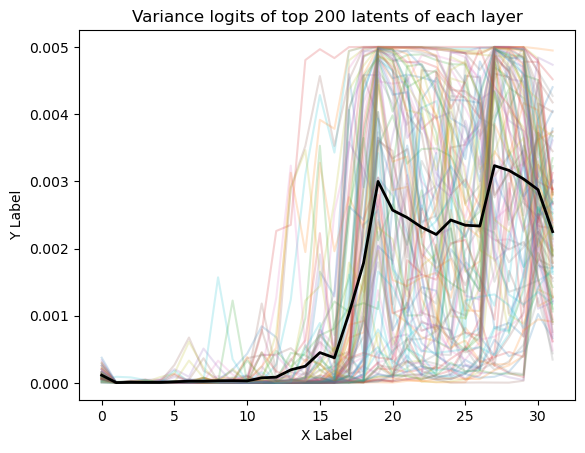

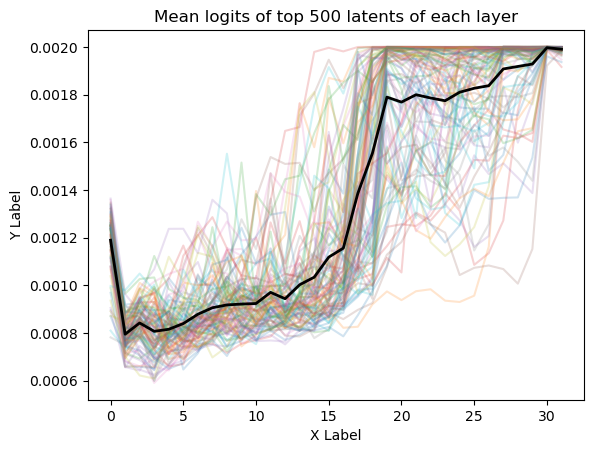

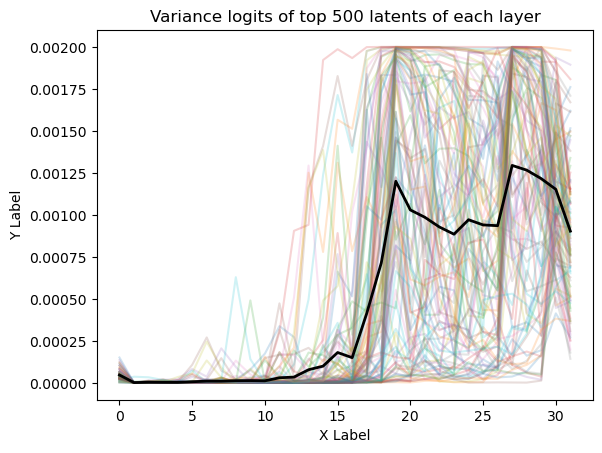

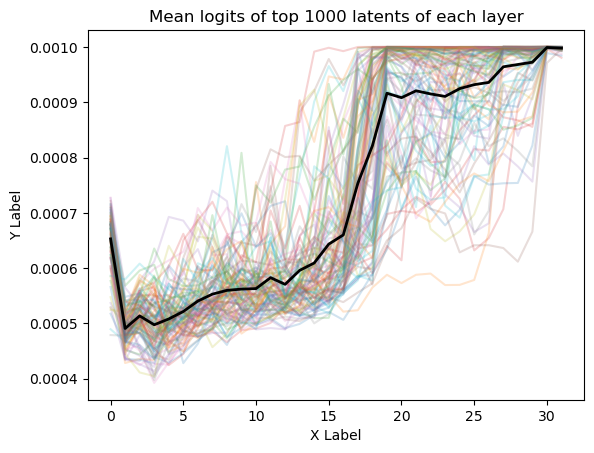

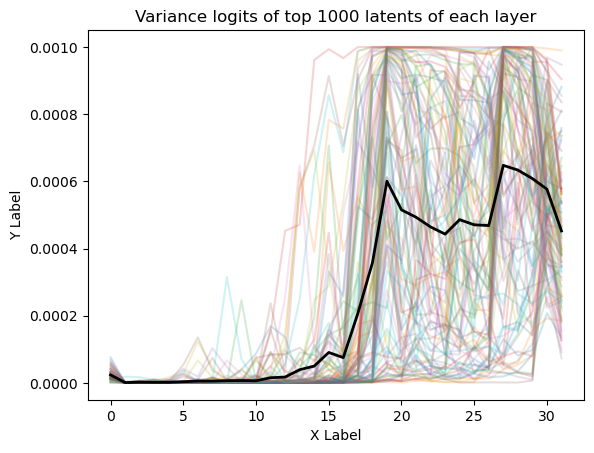

In [45]:
latents_tensor = torch.stack(latents_all, dim = 0)
k_choice = [10, 50, 100, 200, 500, 1000]
for k in k_choice:
    topk_latents, topk_indices = torch.topk(latents_tensor, k, dim=-1)
    topk_mean_all = torch.mean(topk_latents, dim=-1)
    topk_mean = torch.mean(topk_mean_all, dim=0)
    topk_variance_all = torch.var(topk_latents, dim=-1)
    topk_variance = torch.mean(topk_variance_all, dim=0)
    # print(f"{topk_mean.shape=}")
    # print(f"{topk_mean_all.shape=}")
    plot_with_mean(topk_mean, topk_mean_all, title = f'Mean logits of top {k} latents of each layer')
    plot_with_mean(topk_variance, topk_variance_all, title = f'Variance logits of top {k} latents of each layer')
    

In [3]:

def select(replacement, attn_mask, batch_tokens, model, layers) -> dict:
    substituted_cache = {}
    def replacement_hook(activation: torch.Tensor, hook:Any):
        # print(activation.shape)
        # print(hook.name)
        substituted_cache[hook.name] = activation
        # print(torch.allclose(activation, replacement_tensor, atol=1e-6))
        if hook.name == substituted_layer:
            return replacement
        
    fwd_hooks = [(f"blocks.{i}.hook_resid_post", replacement_hook) for i in layers]
    recons_logits, recons_loss =model.run_with_hooks(
    batch_tokens, 
    attention_mask=attn_mask,
    return_type="both",
    fwd_hooks=fwd_hooks)
    return substituted_cache


attention_channeling = cache[substituted_layer]


substituted_cache = select(replacement=attention_channeling, attn_mask=attn_mask, batch_tokens=tokens, model=model, layers= layers)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
